# Handling Missing Values in Python


In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

## Reading in the dataset
* Reading in the Titanic Dataset.

In [2]:
os.listdir('../input/titanic')

['train.csv', 'test.csv', 'gender_submission.csv']

In [3]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

# First few rows of the training dataset
train.head()


Training data shape:  (891, 12)
Testing data shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Examining the Target column 

>For each passenger in the test set, we need to create a model that predicts whether or not the passengers survived the sinking of the Titanic. Hence Survived is that target column in the dataset. Let's examine the Distribution of the target column

In [4]:
 
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

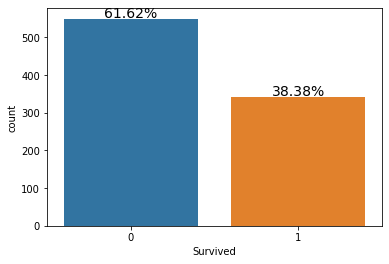

In [5]:
s = sns.countplot(x = 'Survived',data = train)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14) 

Here:
* 0: Did not Survive while 
* 1: Survived. 

Clearly, less people survived the accident.

>Since the focus of the notebook is to detect and handle missing values, we'll jump directly into it. Let's now look at a step by step process to manage the missing values in a dataset.
<hr>

# Detecting Missing values

## Detecting missing values numerically 

>The first step is to detect the count/percentage of missing values in every column of the dataset. This will give an idea about the distribution of missing values.

In [6]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns



In [7]:
train_missing= missing_values_table(train)
train_missing

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [8]:
test_missing= missing_values_table(test)
test_missing

Your selected dataframe has 11 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


Both the train and test set have the same proportion of the missing values. 

## Detecting missing data visually using Missingno library

>To graphically analyse the missingness of the data, let's use a library called [Missingno](https://github.com/ResidentMario/missingno) It is a package for graphical analysis of missing values. To use this library, we need to import it as follows: `import missingno as msno`

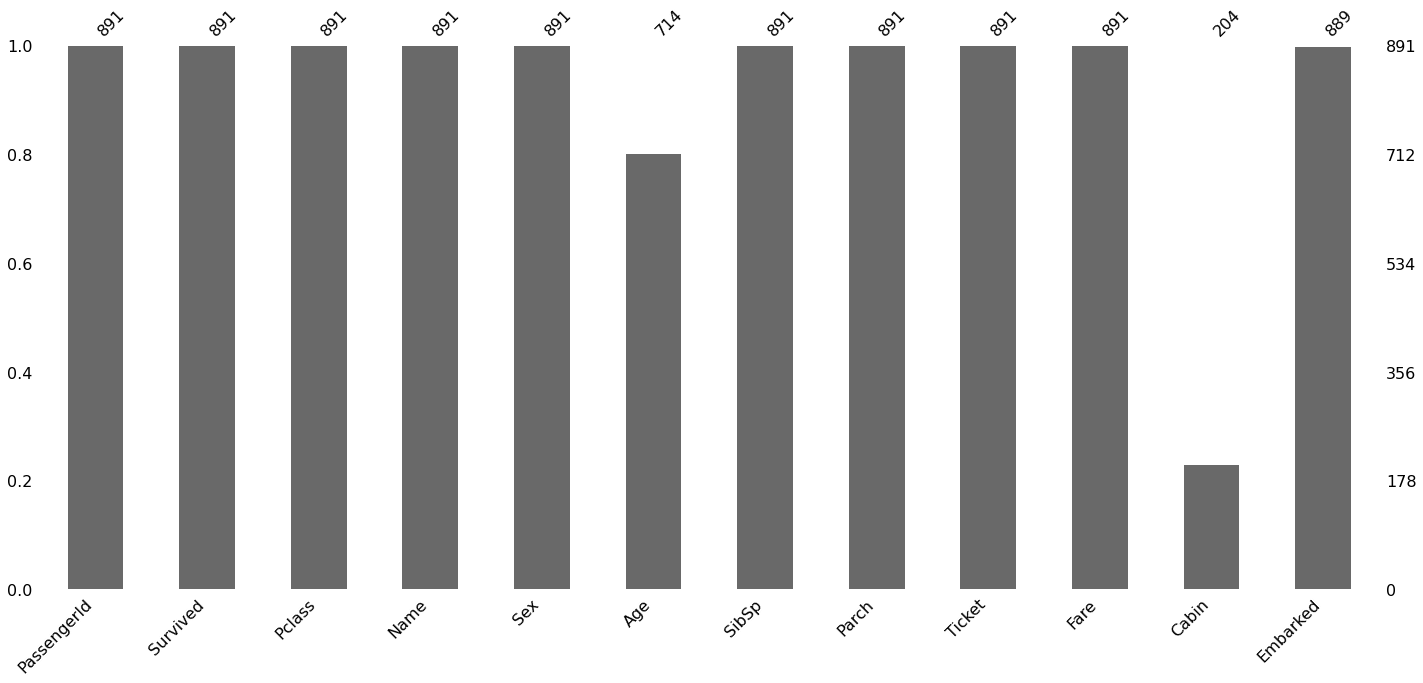

In [9]:
msno.bar(train)

>The bar chart above gives a quick graphical overview of the completeness of the dataset. We can see that Age, Cabin and embarked columns have missing values. Next,it would make sense to find out the locations of the missing data.

### Visualizing the locations of the missing data 

>The [msno.matrix](https://github.com/ResidentMario/missingno#matrix) nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.


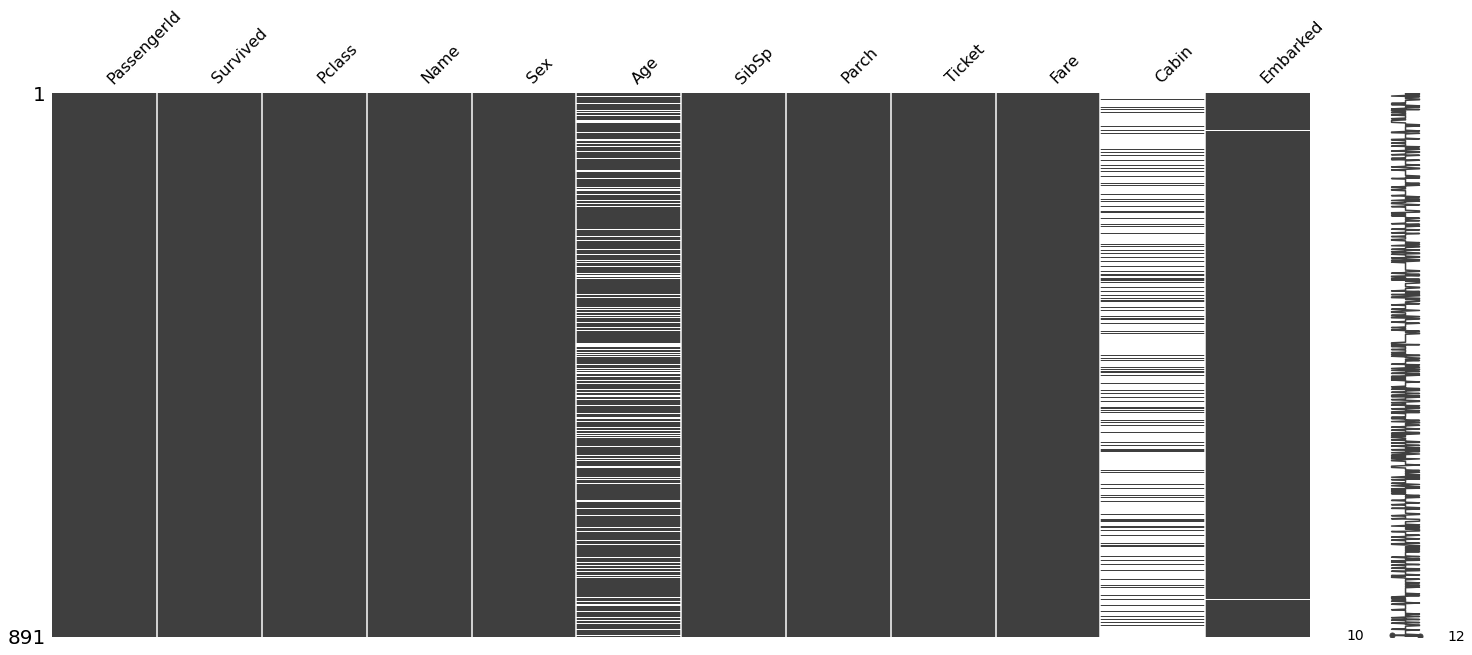

In [10]:
msno.matrix(train)

>* The plot appears blank(white) wherever there are missing values. For instance, in Embarked column there are only two instances of missing data, hence the two white lines.
>
>* The sparkline on the right gives an idea of the general shape of the completeness of the data and points out the row with the minimum nullities and the total number of columns in a given dataset, at the bottom.
>
>It is also possible to sample the dataset to pinpoint the exact location of the missing values. For instance let's check the first 100 rows.

# Reasons for Missing Values 



**1. Missing Completely at Random (MCAR) **

>The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

**2. Missing at Random (MAR) **

>MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.

**3. Missing Not at Random (MNAR) **
>Missingness depends on unobserved data or the value of the missing data itself. 

*All definitions taken from Wikipedia: https://en.wikipedia.org/wiki/Missing_data*




## Finding reason for missing data using matrix plot 

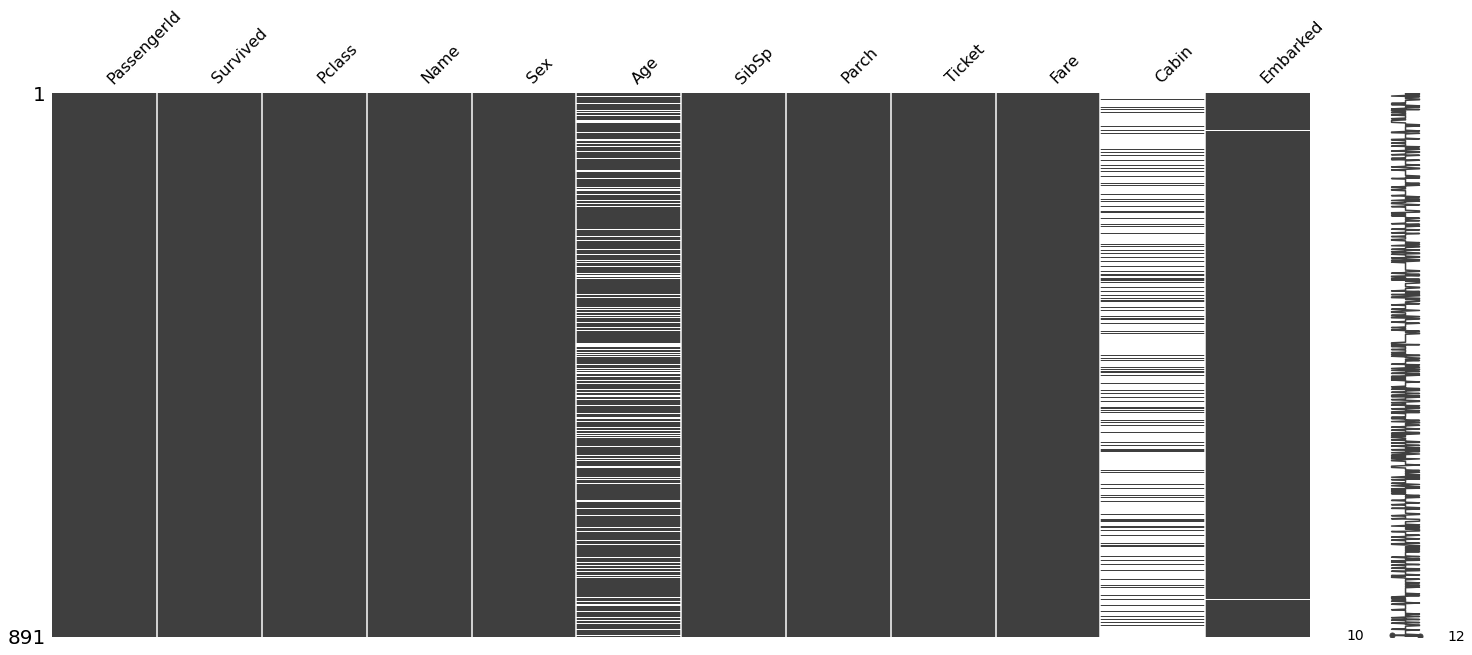

In [12]:
msno.matrix(train)

>* The `Embarked` Column has very few missing values and donot seem to be correlated with any other column, Hence, the missingness in Embarked column can be attributed as Missing Completely at Random.
* Both the `Age` and the `Cabin` columns have a lot of missing values.This could be a case of MAR as we cannot directly observe the reason for missingness of data in these columns.

The missingno package also let's us sort the graph by a particluar column. Let's sort the values by `Age` and `Cabin` column to see if there is a pattern in the missing values

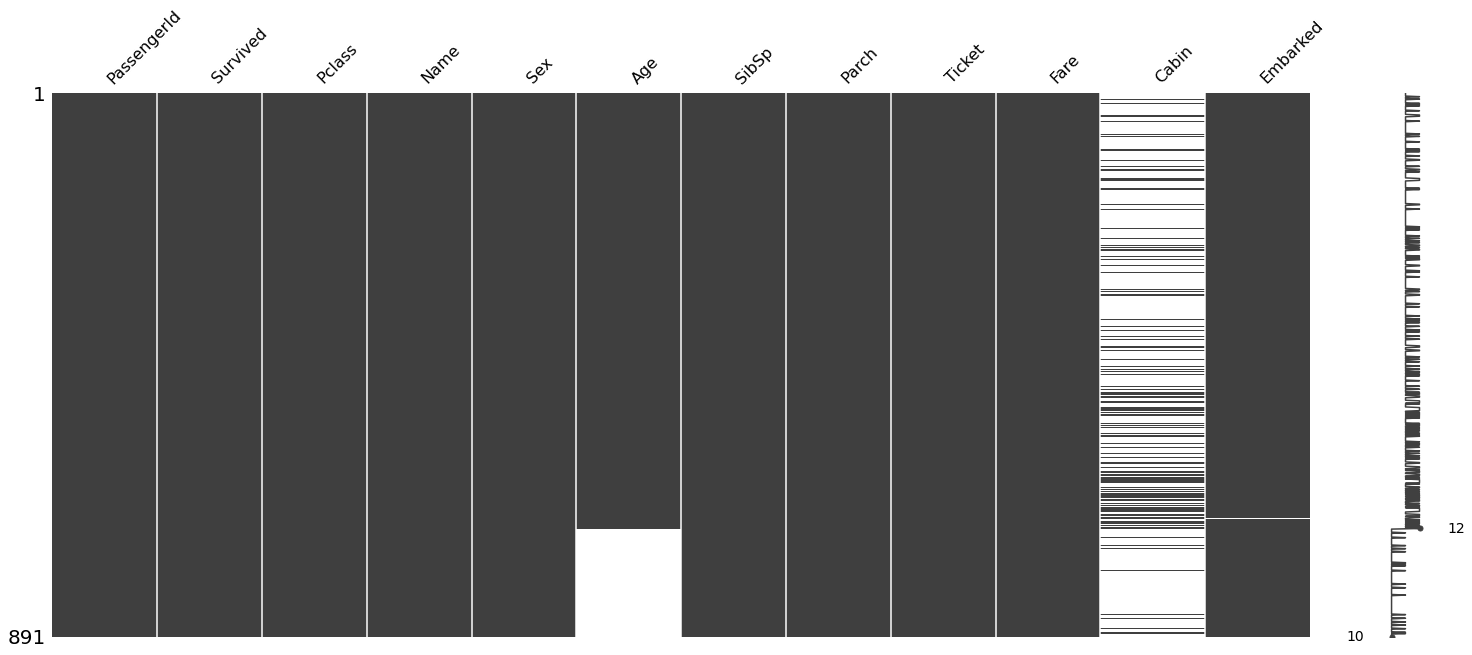

In [13]:
#sorted by Age
sorted = train.sort_values('Age')
msno.matrix(sorted)

Hence it is clear that here is no relation between the missingness in Age and Cabin column.To cement this conclusion further we can also draw a Heatmap among the different variables in the dataset.

## Finding reason for missing data using a Heatmap 

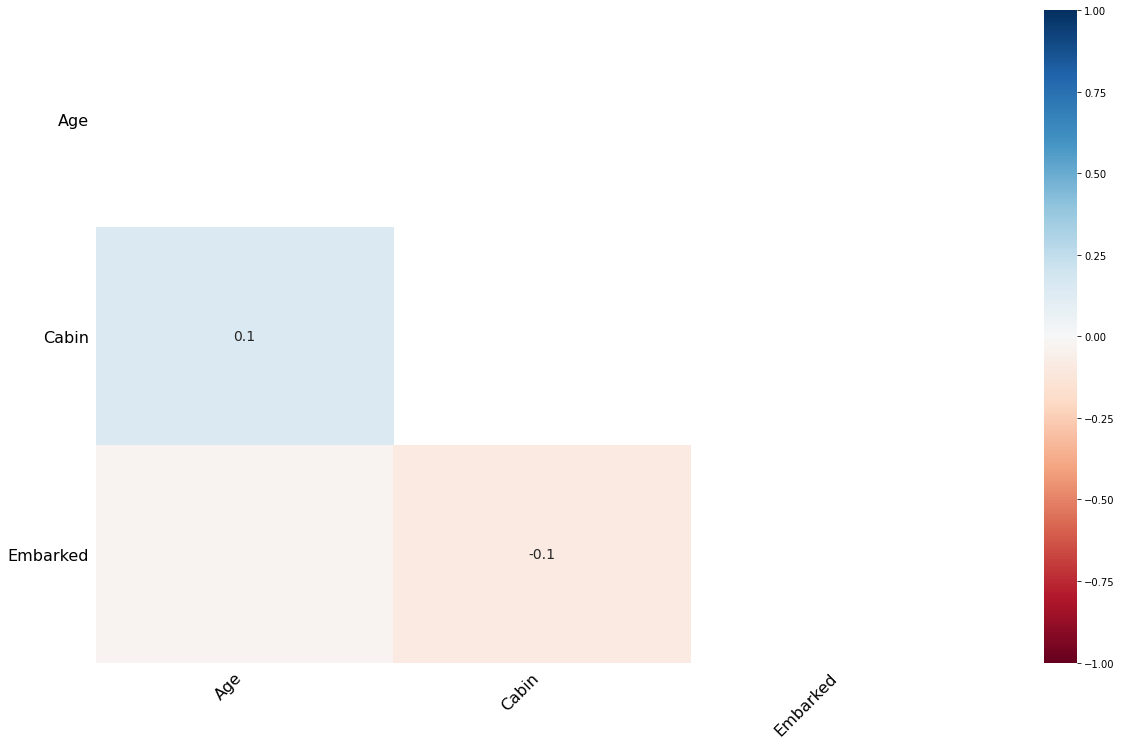

In [14]:
msno.heatmap(train)

The heatmap function shows that there are no strong correlations between missing values of different features. This is good; low correlations further indicate that the data are MAR.

# Treating Missing values  



In [16]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
train_1 = train.copy()
train_1['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

29.69911764705882


### Listwise Deletion/ Dropping rows

>During Listwise deletion, complete rows(which contain the missing values) are deleted. As a result, it is also called Complete Case deletion. Like Pairwise deletion, listwise deletions are also only used for MCAR values.


In [18]:
#Drop rows which contains any NaN or missing value for Age column
train_1.dropna(subset=['Age'],how='any',inplace=True)
train_1['Age'].isnull().sum()

0

>The Age column doesn't have any missing values.A major diadvantage of Listwise deletion is that a major chunk of data and hence a lot of information is lost. Hence, it is advisable to use it only when the number of missing values is very small.


### Dropping complete columns 

If a column contains a lot of missing values, say more than 80%, and the feature is not significant, you might want to delete that feature. However, again, it is not a good methodology to delete data.


## Imputations Techniques for non Time Series Problems 


### Basic Imputation Techniques
  
  - Imputating with a constant value
  - Imputation using the statistics (mean, median or most frequent) of each column in which the missing values are located

For this we shall use the `The SimpleImputer` class from sklearn.

In [19]:
# imputing with a constant

from sklearn.impute import SimpleImputer
train_constant = train.copy()
#setting strategy to 'constant' 
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [20]:
from sklearn.impute import SimpleImputer
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [21]:
train_most_frequent.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Imputations Techniques for Time Series Problems

Now let's look at ways to impute data in a typical time series problem. Tackling missing values in time Series problem is a bit different. The `fillna()` method is used for imputing missing values in such problems.

* Basic Imputation Techniques
  - 'ffill' or 'pad' - Replace NaN s with last observed value
  - 'bfill' or 'backfill' - Replace NaN s with next observed value
  -  Linear interpolation method

### Time Series dataset

The dataset is called [Air Quality Data in India (2015 - 2020)](https://www.kaggle.com/rohanrao/air-quality-data-in-india) Tand it contains air quality data and AQI (Air Quality Index) at hourly and daily level of various stations across multiple cities in India.The dataset has a lot of missing values and and is a classic Time series problem.

In [22]:
os.listdir('../input/air-quality-data-in-india')

['stations.csv',
 'station_hour.csv',
 'city_day.csv',
 'city_hour.csv',
 'station_day.csv']

In [23]:
city_day = pd.read_csv('../input/air-quality-data-in-india/city_day.csv',parse_dates=True,index_col='Date')
city_day1=city_day.copy(deep=True)
city_day.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


I won't go much into explaining the data since I have done a lot of relatedw work in my kernel titled [😷 Breathe India: COVID-19 effect on Pollution](https://www.kaggle.com/parulpandey/breathe-india-covid-19-effect-on-pollution).In this notebook, let's keep our focus on the missing values only. As id evident, city_day dataframe consists of daily pollution level data of some of the prominent cities in India.



In [24]:
#Missing Values
city_day_missing= missing_values_table(city_day)
city_day_missing

Your selected dataframe has 15 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,18109,61.3
PM10,11140,37.7
NH3,10328,35.0
Toluene,8041,27.2
Benzene,5623,19.0
AQI,4681,15.9
AQI_Bucket,4681,15.9
PM2.5,4598,15.6
NOx,4185,14.2
O3,4022,13.6


There are a lot of missing values and some of the columns like Xylene and PM10 have more than 50% of the values missing. Let's now see how we can impute these missing values.



In [25]:
# Imputation using ffill/pad
# Imputing Xylene value

city_day['Xylene'][50:64]


Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
Name: Xylene, dtype: float64

Above we see, there are 3 missing values in the Xylene column. 

### Imputing using ffill

In [26]:
city_day.fillna(method='ffill',inplace=True)
city_day['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26     0.81
2015-02-27     0.81
2015-02-28     0.81
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06     4.13
Name: Xylene, dtype: float64

We can see that all missing values have been filled with the last observed values.

### Imputation using bfill

In [27]:
# Imputing AQI value

city_day['AQI'][20:30]

Date
2015-01-21      NaN
2015-01-22      NaN
2015-01-23      NaN
2015-01-24      NaN
2015-01-25      NaN
2015-01-26      NaN
2015-01-27      NaN
2015-01-28      NaN
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

In [28]:
city_day.fillna(method='bfill',inplace=True)
city_day['AQI'][20:30]

Date
2015-01-21    209.0
2015-01-22    209.0
2015-01-23    209.0
2015-01-24    209.0
2015-01-25    209.0
2015-01-26    209.0
2015-01-27    209.0
2015-01-28    209.0
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

We can see that all missing values have been filled with the next observed values.

### Imputation using Linear Interpolation method

Time series data has a lot of variations against time. Hence, imputing using backfill and forward fill isn't the ebst possible solution to address the missing value problem. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.

[Linear interpolation](https://www.lexjansen.com/nesug/nesug01/ps/ps8026.pdf) is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point. 

Refer to the official documentation for a complete list of interpolation strategies [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In [29]:
city_day1['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06      NaN
Name: Xylene, dtype: float64

In [30]:
# Interpolate using the linear method
city_day1.interpolate(limit_direction="both",inplace=True)
city_day1['Xylene'][50:65]

Date
2015-02-20     7.4800
2015-02-21    15.4400
2015-02-22     8.4700
2015-02-23    28.4600
2015-02-24     6.0500
2015-02-25     0.8100
2015-02-26     0.9375
2015-02-27     1.0650
2015-02-28     1.1925
2015-03-01     1.3200
2015-03-02     0.2200
2015-03-03     2.2500
2015-03-04     1.5500
2015-03-05     4.1300
2015-03-06     2.2600
Name: Xylene, dtype: float64

## Advanced Imputation Techniques 

Advanced imputation techniques uses machine learning algorithms to impute the missing values in a dataset unlike the previous techniques where we used other column values to predict the missing values. We shall look at the following two techniques in this notebook:

* [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)
* [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

### K-Nearest Neighbor Imputation

The [KNNImputer class](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) provides imputation for filling in missing values using the k-Nearest Neighbors approach.Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. 

In [31]:
train_knn = train.copy(deep=True)

In [32]:
from sklearn.impute import KNNImputer
train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_knn['Age'] = knn_imputer.fit_transform(train_knn[['Age']])

In [33]:
train_knn['Age'].isnull().sum()


0

### Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:



In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = train.copy(deep=True)

mice_imputer = IterativeImputer()
train_mice['Age'] = mice_imputer.fit_transform(train_mice[['Age']])

In [35]:
train_mice['Age'].isnull().sum()

0

# Algorithms which handle missing values

Some algprithms like XGBoost and LightGBM can handle missing values without any preprocessing, by supplying relevant parameters.

# Conclusion

Well, there is no single best way to handle missing values. One needs to experiment with different methods and then decide which method is best for a particular problem.

# References and good resources 

* [Dealing with Missing Data in Python](https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/the-problem-with-missing-data?ex=1)
* [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)